In [16]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import plotly
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
import warnings
warnings.filterwarnings("ignore")
import re

In [17]:
train = pd.read_csv('../input/weekend-hackathon-edition-2-sentiment/train.csv')
test = pd.read_csv('../input/weekend-hackathon-edition-2-sentiment/test.csv')
submission = pd.read_csv('../input/weekend-hackathon-edition-2-sentiment/submission.csv')

In [18]:
train.head()

,ID,author,Review,Sentiment
0,39467,rayinstirling,Today I'm working on my &quot;Quirky Q&quot; c...,2
1,30154,DirtyRose17,@ShannonElizab dont ya know? people love the h...,1
2,16767,yoliemichelle,ughhh rejected from the 09 mediation program. ...,0
3,9334,jayamelwani,@petewentz im so jealous. i want an octo drive,0
4,61178,aliisanoun,I remember all the hype around this movie when...,0


In [19]:
def clean(x):
    x = re.sub(r'@\w+'," ",x)
    x = re.sub(r'[^a-zA-Z]'," ",x)
    x = re.sub(r' [a-zA-Z]{1} '," ",x)
    return x

merge = pd.concat([train,test]).reset_index(drop=True)
merge["Review_word_len"] = merge.apply(lambda x:len(re.findall(r"\w+",x['Review'])),axis=1)
m = merge.groupby('author')['Review_word_len'].agg(['mean','max',"min"])


In [22]:
merge = merge.merge(m,on='author',how="left")
merge

,ID,author,Review,Sentiment,Review_word_len,mean,max,min
0,39467,rayinstirling,Today I'm working on my &quot;Quirky Q&quot; c...,2.0,18,18.00,18,18
1,30154,DirtyRose17,@ShannonElizab dont ya know? people love the h...,1.0,9,238.00,690,9
2,16767,yoliemichelle,ughhh rejected from the 09 mediation program. ...,0.0,8,86.00,164,8
3,9334,jayamelwani,@petewentz im so jealous. i want an octo drive,0.0,9,90.00,171,9
4,61178,aliisanoun,I remember all the hype around this movie when...,0.0,592,190.00,592,3
...,...,...,...,...,...,...,...,...
62995,46435,nnurse,This show comes up with interesting locations ...,NaN,232,99.25,232,8
62996,30492,___shannon,haha. i love you too aimeeeeeee!,NaN,6,7.50,9,6
62997,4844,davejlewis,another rainy day,NaN,3,51.00,99,3
62998,14932,awaisnaseer,wanted to sleep but a friend from Denmark just...,NaN,13,161.00,461,9


In [4]:
!pip install transformers
!pip install -U sentence-transformers

     |████████████████████████████████| 85 kB 947 kB/s eta 0:00:01
  Created wheel for sentence-transformers: filename=sentence_transformers-2.0.0-py3-none-any.whl size=126709 sha256=49962409488131de08ceb8dc84458c1a2d1b9f3e83fe787e27aa3f24ecd0b5ec
  Stored in directory: /root/.cache/pip/wheels/d1/c1/0f/faafd427f705c4b012274ba60d9a91d75830306811e1355293
Successfully built sentence-transformers


In [23]:
import tensorflow as tf
import tensorflow.keras.backend as K
from sklearn.model_selection import StratifiedKFold
import tokenizers
from sklearn.metrics import log_loss
print('TF version',tf.__version__)

TF version 2.4.1


In [6]:
from sentence_transformers import SentenceTransformer
sentence_embedder = SentenceTransformer('roberta-large-nli-stsb-mean-tokens')

Downloading:   0%|          | 0.00/748 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.98k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/690 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/229 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/239 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/335 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/798k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/191 [00:00<?, ?B/s]

In [24]:
%%time
sentence_embeddings = sentence_embedder.encode(merge.Review.values.tolist(), \
                                               batch_size=64,show_progress_bar=True)

Batches:   0%|          | 0/985 [00:00<?, ?it/s]

CPU times: user 6min 51s, sys: 994 ms, total: 6min 52s
Wall time: 6min 40s


In [25]:
data = pd.DataFrame(sentence_embeddings)
for i in ["Review_word_len","Sentiment","mean","max","min"]:
    data[i] = merge[i].values
data.head()

,0,1,2,3,4,5,6,7,8,9,...,1019,1020,1021,1022,1023,Review_word_len,Sentiment,mean,max,min
0,0.672551,0.194147,-0.908800,-1.594246,0.000508,-0.674034,-0.120664,0.041949,-0.460448,-0.422310,...,0.661459,0.831679,-0.275195,-1.817729,0.637117,18,2.0,18.0,18,18
1,-1.022237,-0.263740,-0.214722,-0.609606,0.717145,-0.789688,-0.904173,1.316874,-0.631662,0.961244,...,0.098602,-1.173507,1.024193,-1.900650,1.140133,9,1.0,238.0,690,9
2,0.133167,-0.506123,-0.904311,-0.407015,0.022147,0.855903,0.683933,0.304534,0.420205,0.464127,...,1.555687,0.379966,-1.072332,-1.072255,-0.719595,8,0.0,86.0,164,8
3,-0.087538,0.918133,-0.693435,-0.378670,-0.130610,-1.010182,-0.944712,2.103151,0.350878,-0.116999,...,0.886465,-0.156292,-0.459526,0.886595,-0.025022,9,0.0,90.0,171,9
4,-0.433981,1.113448,0.004711,-0.085402,0.785661,-0.638683,0.310933,-0.881686,0.028823,0.041442,...,1.012675,0.082560,1.275472,-1.096503,0.720577,592,0.0,190.0,592,3


In [26]:
train = data[~data.Sentiment.isna()]
test = data[data.Sentiment.isna()]
test.drop("Sentiment",axis=1,inplace=True)

0:	learn: 0.6341270	test: 0.6290249	best: 0.6290249 (0)	total: 36.6ms	remaining: 15m 13s
200:	learn: 0.7185091	test: 0.6962585	best: 0.6968254 (198)	total: 4.31s	remaining: 8m 51s
400:	learn: 0.7370181	test: 0.6997732	best: 0.6998866 (359)	total: 8.15s	remaining: 8m 19s
600:	learn: 0.7529762	test: 0.7000000	best: 0.7011338 (588)	total: 12s	remaining: 8m 5s
800:	learn: 0.7678005	test: 0.7006803	best: 0.7018141 (773)	total: 16s	remaining: 8m 2s
1000:	learn: 0.7811224	test: 0.7017007	best: 0.7026077 (918)	total: 19.7s	remaining: 7m 53s
1200:	learn: 0.7939342	test: 0.7035147	best: 0.7046485 (1086)	total: 23.5s	remaining: 7m 45s
1400:	learn: 0.8054138	test: 0.7041950	best: 0.7052154 (1368)	total: 27.5s	remaining: 7m 43s
1600:	learn: 0.8170068	test: 0.7047619	best: 0.7054422 (1410)	total: 31.9s	remaining: 7m 45s
1800:	learn: 0.8288832	test: 0.7040816	best: 0.7056689 (1748)	total: 35.7s	remaining: 7m 40s
2000:	learn: 0.8413832	test: 0.7056689	best: 0.7062358 (1955)	total: 39.3s	remaining: 7m 

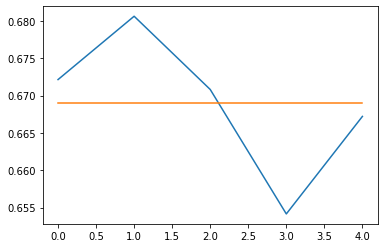

In [27]:
X = train.drop(['Sentiment'],axis=1)
y = train['Sentiment']

params = {
    "od_type":"Iter",
    "od_wait":150,
    "iterations":25000,
    'learning_rate':0.0355,
    "eval_metric":"Accuracy",
    "task_type":"GPU",
    "boosting_type":"Plain"
}

best_score = np.inf
scores = []

fold_large = KFold(n_splits=5,shuffle=True,random_state=1240)
for train_idx,test_idx in fold_large.split(X,y):
    train_set = (X.iloc[train_idx],y.iloc[train_idx])
    test_set = (X.iloc[test_idx],y.iloc[test_idx])
    
    model = CatBoostClassifier(**params)
    model.fit(*train_set,
             eval_set=[test_set],early_stopping_rounds=500,verbose=200)
    
    score = log_loss(test_set[1].values,model.predict_proba(test_set[0]))
    print(score)
    scores.append(score)
    
    if score < best_score:
        best_score = score
        best_model = model
        
    print('===='*50)

print(f"Mean Score : {np.array(scores).mean()}")
print(f"Min Score : {np.array(scores).min()}")
print(f"Max Score : {np.array(scores).max()}")

plt.plot(scores)
plt.plot(np.arange(len(scores)),[np.array(scores).mean()]*len(scores),)
plt.show()
        
model_large = best_model

In [28]:
m = pd.DataFrame(list(zip(X.columns,model_large.feature_importances_))).sort_values(1,ascending=False)
m

,0,1
1024,Review_word_len,8.763205
655,655,4.413781
1026,max,3.274387
97,97,1.825353
874,874,1.473684
...,...,...
109,109,0.000000
114,114,0.000000
723,723,0.000000
902,902,0.000000


In [29]:
submission_df = pd.DataFrame(model_large.predict_proba(test),columns = ['Negative_0','Neutral_1','Positive_2'])
submission_df.to_csv('my_submission_file.csv', index=False)
submission_df

,Negative_0,Neutral_1,Positive_2
0,0.106261,0.153741,0.739999
1,0.537259,0.336761,0.125980
2,0.609426,0.002940,0.387634
3,0.804774,0.091963,0.103263
4,0.127916,0.584625,0.287458
...,...,...,...
18895,0.401660,0.013131,0.585209
18896,0.120468,0.105598,0.773934
18897,0.756046,0.161883,0.082072
18898,0.549021,0.235685,0.215293


In [30]:
embedder2 = SentenceTransformer('bert-large-nli-stsb-mean-tokens')

Downloading:   0%|          | 0.00/690 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.96k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/632 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/229 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/411 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/191 [00:00<?, ?B/s]

In [50]:
%%time
sentence_embeddingss = embedder2.encode(merge.Review.values.tolist(),
                                       batch_size=42,
                                       show_progress_bar=True)

Batches:   0%|          | 0/1500 [00:00<?, ?it/s]

CPU times: user 6min 58s, sys: 1.12 s, total: 6min 59s
Wall time: 6min 46s


In [52]:
data = pd.DataFrame(sentence_embeddingss)
for i in ["Review_word_len","Sentiment","mean","max","min"]:
    data[i] = merge[i].values
data.head()

,0,1,2,3,4,5,6,7,8,9,...,1019,1020,1021,1022,1023,Review_word_len,Sentiment,mean,max,min
0,-0.110012,0.394200,0.296234,0.131038,-1.163575,-0.144945,-0.277614,0.899359,1.037773,0.522974,...,-0.271911,-0.109447,0.620038,0.648482,0.397318,18,2.0,18.0,18,18
1,0.680033,-0.668950,-0.423154,-0.379539,-0.179675,0.403294,-0.306203,0.190556,0.002006,-0.621568,...,-0.695394,0.633384,-1.147570,0.468758,0.683321,9,1.0,238.0,690,9
2,0.634790,-0.827528,-0.294263,0.647961,0.186201,-0.277738,0.701417,-0.506094,-1.102508,0.341414,...,0.104852,0.852666,-0.787654,-0.344795,-0.031216,8,0.0,86.0,164,8
3,0.751422,-0.797424,-0.470955,-0.090923,-0.384502,-0.164062,-0.218467,-0.549153,0.014415,0.015375,...,-0.976967,-0.616738,-0.599507,0.138602,-0.048197,9,0.0,90.0,171,9
4,0.448682,-0.290660,-0.017640,-1.555825,-0.158519,0.461414,-0.948493,0.580037,-0.053897,0.156537,...,-0.005920,0.017059,-0.232225,0.806156,0.197148,592,0.0,190.0,592,3


In [53]:
train = data[~data.Sentiment.isna()]
test = data[data.Sentiment.isna()]
test.drop("Sentiment",axis=1,inplace=True)

In [54]:
X = train.drop('Sentiment',axis=1)
y = train['Sentiment']
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=0)

In [55]:
catboost=CatBoostClassifier(iterations=1000,task_type='GPU')
lgbm=LGBMClassifier(n_estimators=100,device="gpu",max_bin=25)
from sklearn.ensemble import VotingClassifier
vclf=VotingClassifier(estimators=[('lgg',lgbm),('xgg',catboost)],voting='soft')

In [56]:
vclf.fit(X_train,y_train)

Learning rate set to 0.13427


0:	learn: 1.0313234	total: 27.7ms	remaining: 27.6s
1:	learn: 0.9787952	total: 48.5ms	remaining: 24.2s
2:	learn: 0.9388428	total: 69.8ms	remaining: 23.2s
3:	learn: 0.9062006	total: 91.5ms	remaining: 22.8s
4:	learn: 0.8795683	total: 117ms	remaining: 23.2s
5:	learn: 0.8579537	total: 136ms	remaining: 22.5s
6:	learn: 0.8378880	total: 156ms	remaining: 22.1s
7:	learn: 0.8215561	total: 177ms	remaining: 22s
8:	learn: 0.8063867	total: 200ms	remaining: 22.1s
9:	learn: 0.7946298	total: 221ms	remaining: 21.9s
10:	learn: 0.7831995	total: 243ms	remaining: 21.9s
11:	learn: 0.7739259	total: 263ms	remaining: 21.6s
12:	learn: 0.7644674	total: 300ms	remaining: 22.7s
13:	learn: 0.7573604	total: 319ms	remaining: 22.5s
14:	learn: 0.7509779	total: 339ms	remaining: 22.3s
15:	learn: 0.7452334	total: 359ms	remaining: 22.1s
16:	learn: 0.7397638	total: 379ms	remaining: 21.9s
17:	learn: 0.7347353	total: 398ms	remaining: 21.7s
18:	learn: 0.7301127	total: 419ms	remaining: 21.6s
19:	learn: 0.7262338	total: 438ms	remai

VotingClassifier(estimators=[('lgg', LGBMClassifier(device='gpu', max_bin=25)),
                             ('xgg',
                              <catboost.core.CatBoostClassifier object at 0x7f4eb72870d0>)],
                 voting='soft')

In [58]:
submission_df_1 = pd.DataFrame(vclf.predict_proba(test),columns = ['Negative_0','Neutral_1','Positive_2'])
# submission_df.to_csv('my_submission_file.csv', index=False)
submission_df_1

,Negative_0,Neutral_1,Positive_2
0,0.174553,0.260975,0.564472
1,0.629135,0.252880,0.117985
2,0.971837,0.000556,0.027607
3,0.813375,0.109288,0.077338
4,0.055352,0.657550,0.287098
...,...,...,...
18895,0.552189,0.002063,0.445748
18896,0.044476,0.037523,0.918001
18897,0.596105,0.328056,0.075839
18898,0.455828,0.308094,0.236078


In [42]:
embedder3= SentenceTransformer('distilbert-base-nli-stsb-mean-tokens')

Downloading:   0%|          | 0.00/345 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.99k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/555 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/229 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/265M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/505 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [59]:
%%time
sentence_embeddingss = embedder3.encode(merge.Review.values.tolist(),
                                       batch_size=42,
                                       show_progress_bar=True)

Batches:   0%|          | 0/1500 [00:00<?, ?it/s]

CPU times: user 1min 39s, sys: 629 ms, total: 1min 40s
Wall time: 1min 26s


In [61]:
data = pd.DataFrame(sentence_embeddingss)
for i in ["Review_word_len","Sentiment","mean","max","min"]:
    data[i] = merge[i].values
data.head()

,0,1,2,3,4,5,6,7,8,9,...,763,764,765,766,767,Review_word_len,Sentiment,mean,max,min
0,-0.618426,0.449090,1.361033,-0.545008,0.354002,-0.552220,0.355883,-0.464111,0.843285,-0.919467,...,-0.155999,0.400863,0.290077,0.243347,0.537961,18,2.0,18.0,18,18
1,0.274280,0.195633,0.546867,-0.102199,-0.122989,0.082593,0.153912,0.226612,-0.174602,-0.530035,...,1.010162,0.042510,-0.351711,-0.570913,0.122521,9,1.0,238.0,690,9
2,-0.693534,0.650174,0.373411,0.125855,-0.662000,0.252645,-0.256489,0.353814,0.714326,-0.113717,...,-0.359930,-0.174163,-0.479401,0.157722,1.044440,8,0.0,86.0,164,8
3,-0.650105,0.893552,0.573611,-0.490591,-0.674332,0.188111,-0.956550,0.653494,1.024455,-0.064320,...,-0.019497,0.635196,-0.037141,0.374741,-0.856572,9,0.0,90.0,171,9
4,0.353322,0.123477,0.660643,-0.259571,-0.740210,0.050249,-0.076178,-1.051633,0.882124,-0.217822,...,0.188169,0.255681,-0.086384,0.177105,0.242663,592,0.0,190.0,592,3


In [62]:
train = data[~data['Sentiment'].isna()]
test = data[data['Sentiment'].isna()]
test.drop('Sentiment',axis=1,inplace=True)

In [63]:
X = train.drop('Sentiment',axis=1)
y = train['Sentiment']
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=0)

In [64]:
vclf.fit(X_train,y_train)

Learning rate set to 0.13427


0:	learn: 1.0336313	total: 23.7ms	remaining: 23.7s
1:	learn: 0.9848238	total: 41.7ms	remaining: 20.8s
2:	learn: 0.9471094	total: 59.8ms	remaining: 19.9s
3:	learn: 0.9168360	total: 77.7ms	remaining: 19.4s
4:	learn: 0.8922060	total: 95.4ms	remaining: 19s
5:	learn: 0.8720422	total: 114ms	remaining: 18.9s
6:	learn: 0.8530327	total: 137ms	remaining: 19.4s
7:	learn: 0.8378636	total: 154ms	remaining: 19.1s
8:	learn: 0.8252139	total: 171ms	remaining: 18.8s
9:	learn: 0.8137754	total: 188ms	remaining: 18.6s
10:	learn: 0.8024328	total: 204ms	remaining: 18.4s
11:	learn: 0.7931640	total: 221ms	remaining: 18.2s
12:	learn: 0.7858617	total: 240ms	remaining: 18.2s
13:	learn: 0.7794184	total: 256ms	remaining: 18s
14:	learn: 0.7735662	total: 273ms	remaining: 17.9s
15:	learn: 0.7679159	total: 290ms	remaining: 17.8s
16:	learn: 0.7628019	total: 307ms	remaining: 17.7s
17:	learn: 0.7581216	total: 324ms	remaining: 17.7s
18:	learn: 0.7538721	total: 341ms	remaining: 17.6s
19:	learn: 0.7501533	total: 357ms	remain

VotingClassifier(estimators=[('lgg', LGBMClassifier(device='gpu', max_bin=25)),
                             ('xgg',
                              <catboost.core.CatBoostClassifier object at 0x7f4eb72870d0>)],
                 voting='soft')

In [65]:
submission_df_2 = pd.DataFrame(vclf.predict_proba(test),columns = ['Negative_0','Neutral_1','Positive_2'])
# submission_df.to_csv('my_submission_file.csv', index=False)
submission_df_2

,Negative_0,Neutral_1,Positive_2
0,0.247094,0.115416,0.637490
1,0.682278,0.180528,0.137194
2,0.916546,0.000390,0.083064
3,0.864364,0.052089,0.083547
4,0.071979,0.672906,0.255115
...,...,...,...
18895,0.402290,0.001752,0.595958
18896,0.065674,0.054705,0.879622
18897,0.838316,0.114615,0.047068
18898,0.556410,0.224489,0.219100


In [66]:
final=(submission_df+submission_df_1+submission_df_2)/3

In [70]:
final.to_csv('submission_final.csv', index=False)
final

,Negative_0,Neutral_1,Positive_2
0,0.175969,0.176711,0.647320
1,0.616224,0.256723,0.127053
2,0.832603,0.001296,0.166101
3,0.827504,0.084446,0.088049
4,0.085083,0.638360,0.276557
...,...,...,...
18895,0.452046,0.005649,0.542305
18896,0.076873,0.065942,0.857186
18897,0.730156,0.201518,0.068326
18898,0.520420,0.256089,0.223490
